In [72]:
import rasterio
import os
import numpy as np
from shapely.geometry import box
from rasterio.windows import from_bounds, bounds
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib import pyplot

In [106]:
import rasterio
from rasterio.windows import from_bounds, bounds
from shapely.geometry import box

def reproyectar_raster_PP(path_slope = 'Slope_SRTM_Zone_WGS84.tif', path_pp1 = 'output/2024_09_13.tif', path_name_output = 'output/output_pp.tif'):

    with rasterio.open(path_slope) as src1, rasterio.open(path_pp1) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        
        # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        
        # Leer los datos de la ventana de intersección del archivo de precipitación
        data_pp = src2.read(1, window=window)
        print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
        print('bounds:', bounds(window, src1.transform))
        
        left, bottom, right, top = bounds(window, src1.transform)
        new_transform = src1.window_transform(window)
        height = window.height
        width = window.width
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height,
            'transform': new_transform,
            'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
        })
        print(f'kwargs: {kwargs}')
        print(window)
        
        # Creación del nuevo archivo TIFF con los datos de precipitación
        with rasterio.open(path_name_output, 'w', **kwargs) as dst:
            dst.write(data_pp, 1)

In [80]:
"""import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds, bounds
from rasterio.warp import calculate_default_transform
from shapely.geometry import box

path_slope = 'Slope_SRTM_Zone_WGS84.tif'
path_pp1 = 'output/2024_09_10.tif'
path_output = 'output/'

with rasterio.open(path_slope) as src1, rasterio.open(path_pp1) as src2:
    ext1 = box(*src1.bounds)
    ext2 = box(*src2.bounds)
    print(f'ext1: {ext1}\next2: {ext2}')
    
    # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
    intersection = ext1.intersection(ext2)
    print(f'intersection: {intersection}')
    
    window = from_bounds(*intersection.bounds, src1.transform)
    print(f'Ventanas: {window}')
    
    # Leer los datos de la ventana de intersección del archivo de precipitación
    data_pp = src2.read(1, window=window)
    print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
    print('bounds:', bounds(window, src1.transform))
    
    left, bottom, right, top = bounds(window, src1.transform)
    new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, data_pp.shape[1], data_pp.shape[0],
                                                               left, bottom, right, top)
    height = window.height
    width = window.width
    print(f'La ventana es: {width} X {height}, Teniendo: {window}')
    
    kwargs = src1.meta.copy()
    print(kwargs)
    kwargs.update({
        'width': width,
        'height': height,
        'transform': new_transform,
        'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
    })
    print(f'kwargs: {kwargs}')
    print(window)
    
    # Creación del nuevo archivo TIFF con los datos de precipitación
    with rasterio.open(path_output + 'output_pp.tif', 'w+', **kwargs) as dst:
        print('------------------------------------------\n', data_pp)
        reproject(
            source=data_pp,
            destination=rasterio.band(dst, 1),
            src_transform=src2.window_transform(window),
            src_crs=src2.crs,
            dst_crs=src2.crs,
            dst_transform=new_transform,
            resampling=Resampling.bilinear
        )"""

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-68.9459228515625 -36.313880920410156, -68.9459228515625 -48.062965393066406, -78.54290771484375 -48.062965393066406, -78.54290771484375 -36.313880920410156, -68.9459228515625 -36.313880920410156))
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.23380588  0.22872874 ...  0.          0.
   0.        ]
 [ 0.          0.24050066  0.18175383 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.6890626   0.49410963 ... 33.14177    35.983006
   0.        ]
 [ 0.          0.83241224  0.6112833  

In [110]:
def reproyectar_raster_slope(path_slope = 'Slope_SRTM_Zone_WGS84.tif', path_pp = 'output/2024_09_11.tif', path_name_output = 'output/output.tif'):
    with rasterio.open(path_slope) as src1, rasterio.open(path_pp) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        # intersection devuelve la geometria que se comparte entre las geometrias de entradas
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        data = src1.read(window=window)
        print(f'Tipo de dato {type(data)}\nDatos: {data}')
        print('bounds:', bounds(window, src1.transform))
        left, bottom, right, top = bounds(window, src1.transform)
        #calculate default transform: (source coor, target coor, width, height, left, bot,right, top)
        #print('src1.crs',src1.crs)
        #print('src2.crs',src2.crs)
        print('data.shape[1]', data.shape[1])
        print('data.shape[2]', data.shape[2])
        new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, data.shape[2], data.shape[1],
                                                                left, bottom, right, top)
        height = window.height
        width = window.width
        #new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, width, height,
        #                                                           left, bottom, right, top)
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height
        })
        print(f'kwargs: {kwargs}')
        print(window)
        # Creación del nuevo path
        with rasterio.open(path_name_output, 'w+', **kwargs) as dst:
            print('------------------------------------------\n',data)
            reproject(
                source=data,
                destination=rasterio.band(dst, 1),
                src_transform=src1.window_transform(window),
                window=window,
                src_crs=src1.crs,
                dst_crs=src2.crs,
                dst_transform=new_transform,
                resampling=Resampling.bilinear
            )

In [124]:
path_slope = 'output/output.tif'
path_rosetta = 'Soils/ROSETTA_MEAN/alpha_5-15cm.tif'
path_name_output = 'output/output_alpha.tif'
with rasterio.open(path_slope) as src1, rasterio.open(path_rosetta) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        print(f'CRS1: {src1.crs}')
        print(f'CRS2: {src2.crs}')
        # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        
        # Leer los datos de la ventana de intersección del archivo de precipitación
        data_pp = src2.read(1, window=window)
        print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
        print('bounds:', bounds(window, src1.transform))
        
        left, bottom, right, top = bounds(window, src1.transform)
        new_transform = src1.window_transform(window)
        height = window.height
        width = window.width
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height,
            'transform': new_transform,
            'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
        })
        print(f'kwargs: {kwargs}')
        print(window)
        
        # Creación del nuevo archivo TIFF con los datos de precipitación
        with rasterio.open(path_name_output, 'w', **kwargs) as dst:
            dst.write(data_pp, 1)

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-66.104306662 -56.15887467999999, -66.104306662 -17.317874679999996, -75.995306662 -17.317874679999996, -75.995306662 -56.15887467999999, -66.104306662 -56.15887467999999))
CRS1: EPSG:4326
CRS2: EPSG:4326
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
bounds: (-74.042230979, -41.065264796, -70.82414754, -37.936163569)
La ventana es: 11592.0 X 11262.0, Teniendo: Window(col_off=0.0, row_off=0.

In [130]:
# chatgpt funciones
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

def intersect_tiffs(tiff1_path, tiff2_path, output_path):
    """
    Encuentra la intersección entre dos archivos TIFF y crea uno nuevo con los datos del segundo TIFF
    recortados al área de intersección del primero.
    
    Args:
        tiff1_path (str): Ruta al primer archivo TIFF (se usará su extensión)
        tiff2_path (str): Ruta al segundo archivo TIFF (se usarán sus datos)
        output_path (str): Ruta donde se guardará el nuevo TIFF
    """
    
    # Abrir ambos archivos TIFF
    with rasterio.open(tiff1_path) as src1:
        with rasterio.open(tiff2_path) as src2:
            # Obtener los bounds (límites) del primer TIFF
            bounds = src1.bounds
            
            # Verificar si los sistemas de coordenadas son diferentes
            if src1.crs != src2.crs:
                print('CRS diferentes')
                # Calcular la transformación necesaria
                transform, width, height = calculate_default_transform(
                    src2.crs, src1.crs, src2.width, src2.height, *src2.bounds)
                
                # Crear un array temporal para reproyectar
                temp_data = np.zeros((height, width), dtype=src2.dtypes[0])
                
                # Reproyectar los datos del segundo TIFF al CRS del primero
                reproject(
                    source=rasterio.band(src2, 1),
                    destination=temp_data,
                    src_transform=src2.transform,
                    src_crs=src2.crs,
                    dst_transform=transform,
                    dst_crs=src1.crs,
                    resampling=Resampling.nearest
                )
                
                # Actualizar los metadatos para el archivo reproyectado
                profile = src2.profile.copy()
                profile.update({
                    'crs': src1.crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                
                # Crear un dataset temporal con los datos reproyectados
                with rasterio.MemoryFile() as memfile:
                    with memfile.open(**profile) as temp_dataset:
                        temp_dataset.write(temp_data, 1)
                        # Realizar el recorte usando los bounds del primer TIFF
                        out_image, out_transform = mask(temp_dataset, 
                                                      [{'type': 'Polygon', 
                                                        'coordinates': [[
                                                            [bounds.left, bounds.bottom],
                                                            [bounds.left, bounds.top],
                                                            [bounds.right, bounds.top],
                                                            [bounds.right, bounds.bottom],
                                                            [bounds.left, bounds.bottom]
                                                        ]]}],
                                                      crop=True)
            else:
                # Si tienen el mismo CRS, hacer el recorte directamente
                print('CRS iguales')
                out_image, out_transform = mask(src2, 
                                              [{'type': 'Polygon', 
                                                'coordinates': [[
                                                    [bounds.left, bounds.bottom],
                                                    [bounds.left, bounds.top],
                                                    [bounds.right, bounds.top],
                                                    [bounds.right, bounds.bottom],
                                                    [bounds.left, bounds.bottom]
                                                ]]}],
                                              crop=True)
            
            # Preparar el perfil para el archivo de salida
            out_profile = src2.profile.copy()
            out_profile.update({
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform
            })
            
            # Guardar el resultado
            with rasterio.open(output_path, 'w', **out_profile) as dest:
                dest.write(out_image)

# Ejemplo de uso
if __name__ == "__main__":
    path_slope = 'output/output.tif'
    path_rosetta = 'Soils/PIRange-001/PIRange_Bulkd.30-60cm.tif'
    path_name_output = 'output/output_bulkd.tif'
    
    intersect_tiffs(path_slope, path_rosetta, path_name_output)

CRS iguales


In [112]:
reproyectar_raster_slope()
#reproyectar_raster_PP()

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-68.9459228515625 -36.313880920410156, -68.9459228515625 -48.062965393066406, -78.54290771484375 -48.062965393066406, -78.54290771484375 -36.313880920410156, -68.9459228515625 -36.313880920410156))
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  ...
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]]]
bounds: (-74.042230979, -41.06526

# ----------------------------------------

In [91]:
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
output_tif_path = 'output/output.tif'

with rasterio.open(output_tif_path) as src:
    meta = src.meta
    print('Metadatos: ',meta)
    data = src.read(1)
    print('Datos: ',data)
    width = meta['width']
    height = meta['height']
    print(f'Width: {width}\nHeight: {height}')
    window = src.window(*src.bounds)
    print('Ventana: ',window)
    data_window = src.read(1, window=window)
    print('Datos de la ventana: ',data_window)
    
    #lon, lat = -73.219497,-37.7517708

    lon,lat = -73.5688,-40.2737
    row, col = src.index(lon, lat)
    print(f'Row: {row}\nCol: {col}')
    value = data_window[row,col]
    print(f'Valor en ({lon},{lat}): {value}')
    print(np.unique(data_window))
    
    

Metadatos:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 11592, 'height': 11262, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002776124429779156, 0.0, -74.042230979,
       0.0, -0.0002778459622624755, -37.936163569)}
Datos:  [[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]
Width: 11592
Height: 11262
Ventana:  Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Datos de la ventana:  [[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]
Row: 8413


Metadatos:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 11592, 'height': 11262, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002776124429779156, 0.0, -74.042230979,
       0.0, -0.0002778459622624755, -37.936163569)}
Datos:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Width: 11592
Height: 11262
Ventana:  Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Datos de la ventana:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


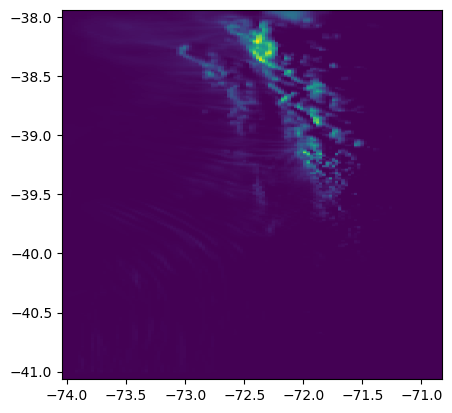

Row: 8413
Col: 1705
Valor en (-73.5688,-40.2737): 0.28800201416015625
[0.0000000e+00 4.6566129e-10 1.1641532e-09 ... 5.4276871e+01 5.4315231e+01
 5.8151337e+01]


In [104]:
import rasterio
from rasterio.windows import Window
from rasterio.plot import show, show_hist
output_tif_path = 'output/output_pp.tif'

with rasterio.open(output_tif_path) as src:
    meta = src.meta
    print('Metadatos: ',meta)
    data = src.read(1)
    print('Datos: ',data)
    width = meta['width']
    height = meta['height']
    print(f'Width: {width}\nHeight: {height}')
    window = src.window(*src.bounds)
    print('Ventana: ',window)
    data_window = src.read(1, window=window)
    print('Datos de la ventana: ',data_window)
    show(src, transform=src.transform, cmap='viridis')
    #lon, lat = -73.219497,-37.7517708

    lon,lat = -73.5688,-40.2737
    row, col = src.index(lon, lat)
    print(f'Row: {row}\nCol: {col}')
    value = data_window[row,col]
    print(f'Valor en ({lon},{lat}): {value}')    
    print(np.unique(data_window))

In [4]:
import numpy as np

from osgeo import gdal, gdalconst, osr
from netCDF4 import Dataset

In [86]:
def nc_to_tif(nc_file_path = 'WRFProno_20240908181246.nc'):
    # convertir archivo nc a tif
    nc_file = Dataset(nc_file_path, 'r')

    lon = nc_file.variables['XLONG'][:]
    lat = nc_file.variables['XLAT'][:]
    lon_min, lon_max = lon.min(), lon.max()
    lat_min, lat_max = lat.min(), lat.max()
    print(f'Latitud {lat_min} {lat_max}')
    print(f'Longitud {lon_min} {lon_max}')

    cols, rows = len(lon[0]), len(lat[0])
    rainnc = nc_file.variables['RAINNC']
    cols, rows = np.size(rainnc[0], 1), np.size(rainnc[0], 0)
    dx = (lon_max - lon_min) / cols
    dy = (lat_max - lat_min) / rows
    transform = [lon_min, dx, 0, lat_min, 0, dy]

    
    string_date = []

    for time_index, timestamp_bytes in enumerate(nc_file.variables['Times']):
        timestamp_str = b''.join(timestamp_bytes).decode('utf-8')
        string_date.append(timestamp_str[:10])

    fec_uni = set(string_date)
    print(fec_uni)
    for ind in fec_uni:
        ind_fec = [indice for indice, valor in enumerate(string_date) if valor == ind]
        print(max(ind_fec), min(ind_fec))
        if min(ind_fec) > 0:
            data1 = rainnc[max(ind_fec), :, :] - rainnc[min(ind_fec)-1, :, :]
        else:
            data1 = rainnc[max(ind_fec), :, :]
        print(data1.shape)
        
        output_tif_path = fr'output/{ind[:4]}_{ind[5:7]}_{ind[8:10]}.tif'    
        driver = gdal.GetDriverByName('GTiff')
        print(f'rows, cols: {output_tif_path} {rows} {cols}')
        output_tiff = driver.Create(output_tif_path, cols,rows,  1, gdal.GDT_Float32)

        output_tiff.SetGeoTransform(transform)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        output_tiff.SetProjection(srs.ExportToWkt())
        print('-'*20,np.flipud(data1))
        #data = np.flipud(data1) # No entiendo
        data = data1
        output_tiff.GetRasterBand(1).WriteArray(data)
        output_tiff = None
    nc_file.close()
    

nc_to_tif()

Latitud -48.062965393066406 -36.313880920410156
Longitud -78.54290771484375 -68.9459228515625
{'2024-09-10', '2024-09-09', '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-08'}
59 36
(213, 120)
rows, cols: output/2024_09_10.tif 213 120
-------------------- [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.83241224  0.6112833  ... 33.386032   36.16939
   0.        ]
 [ 0.          0.6890626   0.49410963 ... 33.14177    35.983006
   0.        ]
 ...
 [ 0.          0.24050066  0.18175383 ...  0.          0.
   0.        ]
 [ 0.          0.23380588  0.22872874 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
35 12
(213, 120)
rows, cols: output/2024_09_09.tif 213 120
-------------------- [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.9396749e+00 2.0101240e+00 ... 1.9958555e+00
  2.4097159e+00 0.0000000e+00]
 [0.0000000e+00 2.24